# Setup

## Imports

In [1]:
# Numpy, Scipy, Matplotlib
import scipy.interpolate
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Drake imports
import pydrake
from pydrake.all import (DiagramBuilder, RigidTransform, MathematicalProgram, RollPitchYaw,
                        RotationMatrix, Meshcat, MeshcatVisualizerParams, MeshcatVisualizerCpp,
                        InverseKinematics, Solve, SpatialInertia, UnitInertia)

# Imports of other project files
import constants
import config

import plant.simulation
import plant.manipulator as manipulator

import ctrl.aux
import plant.pedestal

import visualization

# Other imports
import time

In [2]:
# Matplotlib configuring
# USE FOR PAPER
# plt.style.use(['science', 'no-latex'])
# font = {'size'   : 14}
# matplotlib.rc('font', **font)
# default_figsize = (2*3,2*2)
# USE GENERALLY
font = {'size'   : 16}
matplotlib.rc('font', **font)
default_figsize = (16,8)

In [3]:
matplotlib.rcParams['figure.figsize'] = (16,8)
matplotlib.rcParams['lines.linewidth'] = 5
matplotlib.rcParams["axes.xmargin"] = 0

## Drake initialization

In [4]:
meshcat = Meshcat()
web_url = meshcat.web_url()

[2022-02-09 08:14:02.123] [console] [info] Meshcat listening for connections at http://localhost:7001


### Constants

In [5]:
w_L = constants.nominal_sys_consts.w_L
h_L = constants.nominal_sys_consts.h_L
pedestal_x = plant.pedestal.PEDESTAL_X_DIM

In [6]:
contact_body_name = manipulator.data["contact_body_name"]

### Creat MBP

In [7]:
builder = DiagramBuilder()

mbp_plant, scene_graph = pydrake.multibody.plant.AddMultibodyPlantSceneGraph(
    builder, time_step=1e-3)
mbp_plant.set_stiction_tolerance(constants.v_stiction)
mbp_plant.set_penetration_allowance(0.001)

### Add bodies

In [8]:
# Arm
manipulator.data["add_plant_function"](
    mbp_plant,
    constants.nominal_sys_consts.m_M,
    constants.nominal_sys_consts.r,
    constants.nominal_sys_consts.mu,
    scene_graph = scene_graph
)

ModelInstanceIndex(2)

In [9]:
# Pedestal
plant.pedestal.AddPedestal(mbp_plant)

ModelInstanceIndex(3)

In [10]:
# Paper
paper_instance = mbp_plant.AddModelInstance("paper")
paper_dims = [constants.PLYWOOD_LENGTH, w_L, h_L]
paper_body = mbp_plant.AddRigidBody(
    "paper_body0", paper_instance,
    SpatialInertia(1, p_PScm_E=np.array([0., 0., 0.]),
                   G_SP_E=UnitInertia.SolidBox(*paper_dims))
)

mbp_plant.RegisterCollisionGeometry(
    paper_body, RigidTransform(), pydrake.geometry.Box(*paper_dims), "paper_body0",
    pydrake.multibody.plant.CoulombFriction(1,1)
)
mbp_plant.RegisterVisualGeometry(
    paper_body, RigidTransform(), pydrake.geometry.Box(*paper_dims),
    "paper_body0", [0, 1, 0, 1])
mbp_plant.WeldFrames(
    mbp_plant.world_frame(),
    mbp_plant.GetBodyByName("paper_body0").body_frame(),
    RigidTransform(RotationMatrix(
    ), [0, 0, plant.pedestal.PEDESTAL_Z_DIM+h_L/2])
)

<WeldJoint_[float] name='WorldBody_welds_to_paper_body0' index=14 model_instance=4>

In [11]:
# False body
empty_inertia = SpatialInertia(0, [0, 0, 0], UnitInertia(0, 0, 0))
false_body_instance = mbp_plant.AddModelInstance("false")
mbp_plant.AddRigidBody("false_body", false_body_instance, empty_inertia)

end_effector_z_rotation = mbp_plant.AddJoint(pydrake.multibody.tree.RevoluteJoint(
    "contact_body_name_z_rotation",
    mbp_plant.GetFrameByName(contact_body_name),
    mbp_plant.GetFrameByName("false_body"),
    [0, 0, 1],
    damping=0
))

In [12]:
mbp_plant.Finalize()

### Build diagram

In [13]:
meshcat_params = MeshcatVisualizerParams()
vis = MeshcatVisualizerCpp.AddToBuilder(
    builder,
    scene_graph.get_query_output_port(),
    meshcat,
    meshcat_params)

diagram = builder.Build()
context = diagram.CreateDefaultContext()
ik_context = mbp_plant.GetMyContextFromRoot(context)
vis_context = vis.GetMyContextFromRoot(context)

# Create end effector traj

In [14]:
end_time = 30
DT = 0.1

In [15]:
ts = np.arange(0,end_time,DT);

In [16]:
joint_position = [
    0,
    w_L - constants.PEDESTAL_Y_DIM/2,
    plant.pedestal.PEDESTAL_Z_DIM + constants.nominal_sys_consts.h_L/2
]

In [17]:
desired_radius = w_L/2

In [18]:
theta_Xs = np.interp(
   ts,
    [0, end_time],
    [0, np.pi],
)
ys = joint_position[1] + np.cos(theta_Xs)*desired_radius
zs = joint_position[2] + np.sin(theta_Xs)*desired_radius + constants.nominal_sys_consts.r

# Set margins

In [19]:
# Margin between edge of the link and the CoM of the manipulator
x_margin = 3*constants.IN_TO_M

In [20]:
# Margin from joint limit
q_margin = 20 * np.pi/180

# Get initial values

In [21]:
# Grab bodies and frames
end_effector_body = mbp_plant.GetBodyByName(manipulator.data["contact_body_name"])
end_effector_frame = end_effector_body.body_frame()
false_body_frame = mbp_plant.GetBodyByName("false_body").body_frame()

In [22]:
# Get initial position
starting_q = np.array([
    -1.90831538,
    -0.74013834,
    2.29209901,
    -2.58333082,
    4.52633766,
    0.60032527,
    -3.10678351,
    np.pi
])

In [23]:
# Initialize plant + visualizations
mbp_plant.SetPositions(ik_context, starting_q)
vis.Publish(vis_context)

man_pose = mbp_plant.EvalBodyPoseInWorld(ik_context, mbp_plant.GetBodyByName(contact_body_name))
visualization.AddMeshcatTriad(meshcat, "man_pose", X_PT=man_pose)

false_pose = mbp_plant.EvalBodyPoseInWorld(ik_context, mbp_plant.GetBodyByName("false_body"))
visualization.AddMeshcatTriad(meshcat, "false_pose", X_PT=false_pose)

In [24]:
# Actually grab starting values
starting_ee_pose = mbp_plant.EvalBodyPoseInWorld(ik_context, end_effector_body)
starting_x = starting_ee_pose.translation()[0]
starting_theta_Z = RollPitchYaw(starting_ee_pose.rotation()).vector()[2]

In [25]:
# Grab joint limits
lower_lims_raw = []
upper_lims_raw = []
vel_lims_raw = []
for i in range(1,8):
    jnt = mbp_plant.GetJointByName("panda_joint" + str(i))
    lower_lims_raw.append(jnt.position_lower_limits()[0])
    upper_lims_raw.append(jnt.position_upper_limits()[0])
    
    lower_vel_limit = jnt.velocity_lower_limits()
    upper_vel_limit = jnt.velocity_upper_limits()
    assert -lower_vel_limit == upper_vel_limit
    vel_lims_raw.append(upper_vel_limit[0])
lower_lims_raw = np.array(lower_lims_raw)
upper_lims_raw = np.array(upper_lims_raw)
vel_lims_raw = np.array(vel_lims_raw)

lower_lims = lower_lims_raw + q_margin
upper_lims = upper_lims_raw + q_margin
vel_lims = vel_lims_raw/2

In [26]:
vel_lims

array([1.0875, 1.0875, 1.0875, 1.0875, 1.305 , 1.305 , 1.305 ])

# Run optimization

## Set up geometries for collision checking

In [27]:
geometry_pairs = [
    # ("paper_body0", contact_body_name),
    ("paper_body0", "panda_hand"),
    ("paper_body0", "panda_link8"),
    ("paper_body0", "panda_link7"),
    ("paper_body0", "panda_link6"),
    ("paper_body0", "panda_link5"),
    ("paper_body0", "panda_link4"),
    ("paper_body0", "panda_link3"),
    ("pedestal_left_body", contact_body_name),
    ("pedestal_left_body", "panda_hand"),
    ("pedestal_left_body", "panda_link8"),
    ("pedestal_left_body", "panda_link7"),
    ("pedestal_left_body", "panda_link6"),
    ("pedestal_left_body", "panda_link5"),
    ("pedestal_left_body", "panda_link4"),
    ("pedestal_left_body", "panda_link3"),
    ("pedestal_right_body", contact_body_name),
    ("pedestal_right_body", "panda_hand"),
    ("pedestal_right_body", "panda_link8"),
    ("pedestal_right_body", "panda_link7"),
    ("pedestal_right_body", "panda_link6"),
    ("pedestal_right_body", "panda_link5"),
    ("pedestal_right_body", "panda_link4"),
    ("pedestal_right_body", "panda_link3"),
    ("pedestal_right_body", "panda_link3"),
    ("pedestal_bottom_body", "panda_hand"),
    ("pedestal_bottom_body", "panda_link8"),
    ("pedestal_bottom_body", "panda_link7"),
    ("pedestal_bottom_body", "panda_link6"),
    ("pedestal_bottom_body", "panda_link5"),
    ("pedestal_bottom_body", "panda_link4"),
    ("pedestal_bottom_body", "panda_link3"),
]

# TODO: get this from joints?
adjacent_pairs = [
    ("panda_link0", "panda_link1"),
    ("panda_link1", "panda_link2"),
    ("panda_link2", "panda_link3"),
    ("panda_link3", "panda_link4"),
    ("panda_link4", "panda_link5"),
    ("panda_link5", "panda_link6"),
    ("panda_link6", "panda_link7"),
    ("panda_link6", "panda_link8"),
    ("panda_link7", "panda_link8"),
    ("panda_link7", "panda_hand"),
    ("panda_link8", "panda_hand"),
]
panda_links = ["panda_link" + str(i) for i in range(9)]
panda_links += ["panda_hand"]
for link_1 in panda_links:
    for link_2 in panda_links:
        if link_1 == link_2:
            continue
        if (link_1, link_2) in adjacent_pairs:
            continue
        if (link_2, link_1) in adjacent_pairs:
            continue
        if (link_2, link_1) in geometry_pairs:
            continue
        if (link_1, link_2) in geometry_pairs:
            continue
        geometry_pairs.append((link_1, link_2))

## Run IK

In [28]:
num_iter = 1000

In [29]:
def sample_q():
    q_sample = []
    rng = np.random.default_rng()
    for lb, ub in zip(lower_lims, upper_lims):
        angle_range = ub - lb
        sample = rng.random()*angle_range + lb
        q_sample.append(sample)
    q_sample.append(rng.random()*np.pi*2)
    return q_sample

In [30]:
angle_tol = 1e-4
pos_tol = 1e-4
collision_buffer = 1e-2

In [31]:
best_q = starting_q
best_success_rate = 0
best_successes = []

for _ in range(num_iter):
    init_q = sample_q()
    
    # Output arrays
    qs = []
    # successes = []

    is_success = True
    for t, theta_X, y, z in zip(ts, theta_Xs, ys, zs):
        # Create program
        ik = InverseKinematics(mbp_plant, ik_context, with_joint_limits=True)

        # Add collision contstraints
        for body_name_i, body_name_j in geometry_pairs:
                geo_list = (
                    mbp_plant.GetCollisionGeometriesForBody(
                        mbp_plant.GetBodyByName(body_name_i))[0],
                    mbp_plant.GetCollisionGeometriesForBody(
                        mbp_plant.GetBodyByName(body_name_j))[0],
                )
                ik.AddDistanceConstraint(
                    distance_lower=collision_buffer, distance_upper=1e9, geometry_pair=geo_list)

        # Add position constraint
        p_WG_lower = np.array([[-pos_tol, y-pos_tol, z-pos_tol]]).T
        p_WG_upper = np.array([[pos_tol, y+pos_tol, z+pos_tol]]).T
        ik.AddPositionConstraint(
            frameA=mbp_plant.world_frame(), frameB=end_effector_frame, p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower, p_AQ_upper=p_WG_upper)

        # Add orientation constraint
        R_WG = RotationMatrix.MakeXRotation(theta_X)
        ik.AddOrientationConstraint(
            frameAbar=mbp_plant.world_frame(), R_AbarA=R_WG,
            frameBbar=false_body_frame, R_BbarB=RotationMatrix(),
            theta_bound=angle_tol
        )

        # Add joint limit constraints
        for q_, lb, ub in zip(ik.q(), lower_lims, upper_lims):
            ik.prog().AddConstraint(q_ >= lb)
            ik.prog().AddConstraint(q_ <= ub)

        # Set seed as previous q
        if len(qs) == 0:
            # print(init_q)
            ik.prog().SetInitialGuess(ik.q(), init_q)
        else:
            ik.prog().SetInitialGuess(ik.q(), qs[-1])
        
            # Add velocity constraints
            for q_, vel_lim, prev_q_ in zip(ik.q(), vel_lims, qs[-1]):
                ik.prog().AddConstraint(q_ >= prev_q_ - vel_lim*DT)
                ik.prog().AddConstraint(q_ <= prev_q_ + vel_lim*DT)

        # Solve and grab values
        result = Solve(ik.prog())
        if not result.is_success():
            is_success = False
            print("Failed at time {} for iter {}".format(t, _))
            break

        qs.append(result.GetSolution(ik.q()))
    if is_success:
        print("Success!")
        print("Initial position:", qs[0])
        break
init_q = qs[0]

Failed at time 4.6000000000000005 for iter 0
Failed at time 0.0 for iter 1
Failed at time 4.5 for iter 2
Failed at time 7.7 for iter 3
Failed at time 7.7 for iter 4
Failed at time 4.7 for iter 5
Failed at time 7.7 for iter 6
Failed at time 6.5 for iter 7
Failed at time 6.5 for iter 8
Failed at time 6.5 for iter 9
Failed at time 7.7 for iter 10
Success!
Initial position: [ 1.41434569 -0.88926738 -2.10260353 -2.32577571  1.84577743  0.76911041
 -0.46301146  2.53037197]


# Results

## Visualize in meshcat

In [45]:
t = 0
dt = 0.1
xs_out = []
ys_out = []
zs_out = []
theta_Xs_out = []
theta_Ys_out = []
theta_Zs_out = []

for q in qs:
    mbp_plant.SetPositions(ik_context, q)

    # Evaluate end effector pose
    ee_pose = mbp_plant.EvalBodyPoseInWorld(ik_context, end_effector_body)
    xs_out.append(ee_pose.translation()[0])
    ys_out.append(ee_pose.translation()[1])
    zs_out.append(ee_pose.translation()[2])
    theta_Xs_out.append(RollPitchYaw(ee_pose.rotation()).vector()[0])
    theta_Ys_out.append(RollPitchYaw(ee_pose.rotation()).vector()[1])
    theta_Zs_out.append(RollPitchYaw(ee_pose.rotation()).vector()[2])

    # Visualize
    visualization.AddMeshcatTriad(meshcat, "man_pose", X_PT=ee_pose)
    false_pose = mbp_plant.EvalBodyPoseInWorld(
        ik_context, mbp_plant.GetBodyByName("false_body"))
    visualization.AddMeshcatTriad(meshcat, "false_pose", X_PT=false_pose, opacity=0.3)

    # Publish and increment time
    vis.Publish(vis_context)
    time.sleep(dt)
    t += dt

xs_out = np.array(xs_out)
ys_out = np.array(ys_out)
zs_out = np.array(zs_out)
theta_Xs_out = np.array(theta_Xs_out)
theta_Ys_out = np.array(theta_Ys_out)
theta_Zs_out = np.array(theta_Zs_out)

## Plot results

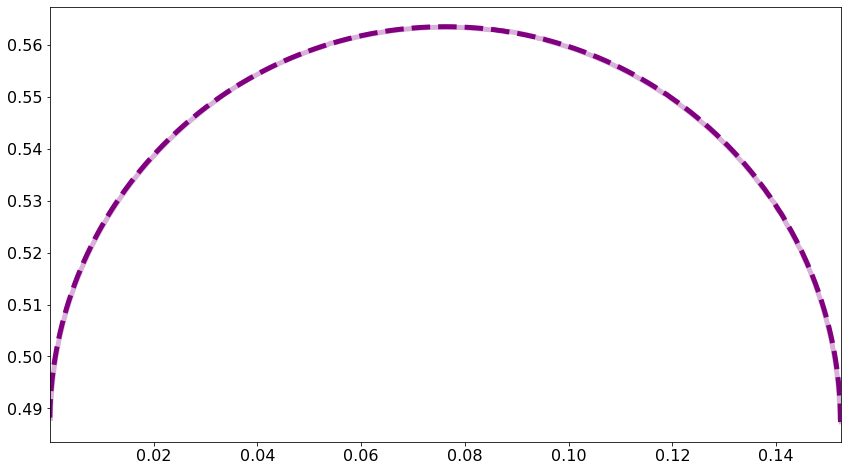

In [33]:
plt.figure()
plt.plot(ys, zs, label="Desired", color='purple', linestyle='--')
plt.plot(ys_out, zs_out, label="Actual", color='purple', alpha=0.3)
plt.gca().set_aspect("equal")

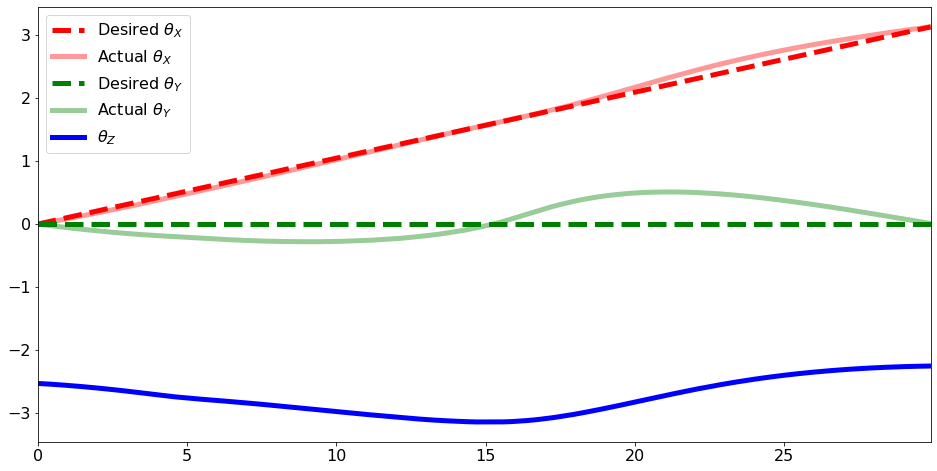

In [34]:
theta_Zs_out_ = theta_Zs_out.copy()
theta_Zs_out_[theta_Zs_out_ > 0] -= np.pi*2

plt.figure()
plt.plot(ts, theta_Xs, label=r"Desired $\theta_X$", color='red', linestyle='--')
plt.plot(ts, -theta_Xs_out, label=r"Actual $\theta_X$", color='red', alpha=0.4)
plt.axhline(0, label=r"Desired $\theta_Y$", color='green', linestyle='--')
plt.plot(ts, -theta_Ys_out, label=r"Actual $\theta_Y$", color='green', alpha=0.4)
plt.plot(ts, theta_Zs_out_, label=r"$\theta_Z$", color='blue')
plt.legend()
# plt.gca().set_aspect("equal")

In [35]:
RollPitchYaw(
    RotationMatrix.MakeXRotation(2).multiply(
        RotationMatrix.MakeZRotation(2))
).vector()

array([-2.40366453, -0.97343351, -2.40366453])

In [36]:
RollPitchYaw([2,0,2]).vector()

array([2., 0., 2.])

In [37]:
RollPitchYaw(
    RotationMatrix.MakeXRotation(2)
).vector()

array([ 2., -0.,  0.])

In [38]:
RollPitchYaw(
    RotationMatrix.MakeZRotation(2)
).vector()

array([ 0., -0.,  2.])

In [39]:
RollPitchYaw(RotationMatrix(RollPitchYaw(
    RotationMatrix.MakeXRotation(2)
)).multiply(RotationMatrix(RollPitchYaw(
    RotationMatrix.MakeZRotation(2)
)))).vector()

array([-2.40366453, -0.97343351, -2.40366453])

## Query meshcat visualization

In [40]:
query_idx = 200

In [41]:
mbp_plant.SetPositions(ik_context, qs[query_idx])
ee_pose = mbp_plant.EvalBodyPoseInWorld(ik_context, end_effector_body)
visualization.AddMeshcatTriad(meshcat, "man_pose", X_PT=ee_pose)
false_pose = mbp_plant.EvalBodyPoseInWorld(
    ik_context, mbp_plant.GetBodyByName("false_body"))
visualization.AddMeshcatTriad(meshcat, "false_pose", X_PT=false_pose, opacity=0.3)
vis.Publish(vis_context)

# Save results

In [42]:
out_qs = np.array(qs)[:,:7]

In [46]:
np.savez("position_traj.npz", qs=out_qs)

In [44]:
# Query visualization